# Market Regime Prediction - Training Pipeline

## Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import numpy as np
import pandas as pd
import json
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from model import MarketRegimeTransformer
import psutil  # For memory monitoring

## Configuration Parameters

In [2]:
# Data parameters
DATA_DIR = 'data/training'
LOOKBACK_WINDOW = 256  # ~1 year of trading data

# Training parameters
BATCH_SIZE = 115
NUM_EPOCHS = 80
LEARNING_RATE = 1e-4
NUM_WORKERS = 10  # Optimal for data loading without overloading system

# Loss weights
CLASS_WEIGHT = 1.0
DURATION_WEIGHT_START = 0.05  # Gradually increase from this
DURATION_WEIGHT_END = 0.4     # To this value

# Model parameters
N_FEATURES = 7  # OHLCV + RSI + BB
D_MODEL = 256
N_HEAD = 8
NUM_FEATURE_LAYERS = 4
NUM_AGGREGATE_LAYERS = 3
DIM_FEEDFORWARD = 1024
DROPOUT = 0.1
NUM_CLASSES = 3  # bull, flat, bear

# Scheduler parameters
WARMUP_EPOCHS = 10

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Device Information

In [3]:
print(f"Using device: {DEVICE}")

if DEVICE.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Usage:")
    print(f"  Allocated: {round(torch.cuda.memory_allocated(0)/1024**3,1)} GB")
    print(f"  Cached: {round(torch.cuda.memory_reserved(0)/1024**3,1)} GB")
    print(f"  Total VRAM: {round(torch.cuda.get_device_properties(0).total_memory/1024**3,1)} GB")
    
    # Enable cuDNN optimizations
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
Memory Usage:
  Allocated: 0.0 GB
  Cached: 0.0 GB
  Total VRAM: 24.0 GB


## Dataset Definition

In [4]:
class HalfLoadedMarketRegimeDataset(Dataset):
    def __init__(self, data_dir, subset='train', lookback_window=256, half='first'):
        """
        Load half of the dataset into RAM at a time
        Args:
            data_dir: Base directory containing train/val subdirectories
            subset: 'train' or 'val'
            lookback_window: The lookback window size (for directory naming)
            half: 'first' or 'second' - which half of files to load
        """
        self.data_dir = os.path.join(data_dir, subset, f'n{lookback_window}')
        self.subset = subset
        self.half = half
        
        # Find all .npz files
        all_files = sorted([f for f in os.listdir(self.data_dir) if f.endswith('.npz')])
        if not all_files:
            raise ValueError(f"No .npz files found in {self.data_dir}")
        
        # Split files into two halves
        mid_point = len(all_files) // 2
        if half == 'first':
            self.files = all_files[:mid_point]
        else:
            self.files = all_files[mid_point:]
        
        print(f"Loading {half} half: {len(self.files)} files from {subset} set...")
        
        # Load all data from this half into memory
        self.data_X = []
        self.data_y_class = []
        self.data_y_duration = []
        
        import psutil
        process = psutil.Process()
        initial_memory = process.memory_info().rss / 1024**3  # GB
        
        for file_idx, file in enumerate(self.files):
            filepath = os.path.join(self.data_dir, file)
            with np.load(filepath) as data:
                self.data_X.append(data['X'].astype(np.float32))
                self.data_y_class.append(data['y_class'].astype(np.int64))
                self.data_y_duration.append(data['y_duration'].astype(np.float32))
            
            if (file_idx + 1) % 50 == 0:
                current_memory = process.memory_info().rss / 1024**3
                print(f"  Loaded {file_idx + 1}/{len(self.files)} files, "
                      f"Memory: {current_memory:.1f} GB (+{current_memory - initial_memory:.1f} GB)")
        
        # Concatenate all data
        self.data_X = np.concatenate(self.data_X, axis=0)
        self.data_y_class = np.concatenate(self.data_y_class, axis=0)
        self.data_y_duration = np.concatenate(self.data_y_duration, axis=0)
        
        self.total_samples = len(self.data_X)
        
        final_memory = process.memory_info().rss / 1024**3
        print(f"Loaded {self.total_samples} samples. Memory usage: {final_memory:.1f} GB "
              f"(+{final_memory - initial_memory:.1f} GB)")
        
    def __len__(self):
        return self.total_samples
    
    def __getitem__(self, idx):
        # Direct indexing from memory - very fast
        return (
            torch.from_numpy(self.data_X[idx]),
            torch.tensor(self.data_y_class[idx], dtype=torch.long),
            torch.tensor(self.data_y_duration[idx], dtype=torch.float32)
        )
    
    def switch_half(self):
        """Switch to the other half of the data"""
        # Clear current data
        del self.data_X
        del self.data_y_class
        del self.data_y_duration
        
        # Switch half
        self.half = 'second' if self.half == 'first' else 'first'
        
        # Reload
        self.__init__(
            self.data_dir.rsplit('/', 2)[0],  # Get base data_dir
            self.subset,
            int(self.data_dir.split('n')[-1]),  # Extract lookback_window
            self.half
        )

## Data Loading Functions

In [5]:
def create_data_loaders_half_loaded(data_dir, batch_size, num_workers, lookback_window):
    """Create data loaders that load half the data at a time
    
    Args:
        data_dir: Base data directory
        batch_size: Batch size for training
        num_workers: Number of worker processes
        lookback_window: Lookback window size
    """
    train_dir = os.path.join(data_dir, 'train', f'n{lookback_window}')
    val_dir = os.path.join(data_dir, 'val', f'n{lookback_window}')
    
    if os.path.exists(train_dir) and os.path.exists(val_dir):
        print("Creating half-loaded data loaders...")
        
        # Start with first half of training data
        train_dataset = HalfLoadedMarketRegimeDataset(
            data_dir, subset='train', lookback_window=lookback_window, 
            half='first'
        )
        
        # Validation can load all at once (it's smaller)
        val_dataset = HalfLoadedMarketRegimeDataset(
            data_dir, subset='val', lookback_window=lookback_window, 
            half='first'  # Val only has 43 files, load all
        )
        
        # Create data loaders with fewer workers since data is in RAM
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True,  # Shuffle within the half
            num_workers=2,  # Few workers needed since data is in RAM
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=2
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size * 2,
            shuffle=False,
            num_workers=1,
            pin_memory=True
        )
        
        return train_loader, val_loader, train_dataset, val_dataset
    
    else:
        raise ValueError(f"Data directories not found.")


def train_epoch_with_halves(model, train_dataset, batch_size, criterion_class, criterion_duration, 
                            optimizer, device, class_weight, duration_weight, epoch):
    """Train for one epoch, switching data halves midway"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    # Train on both halves
    for half in ['first', 'second']:
        if half == 'second':
            print(f"  Switching to second half of data...")
            train_dataset.switch_half()
            
        # Create new dataloader for this half
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True,
            num_workers=2,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=2
        )
        
        print(f"  Training on {half} half ({len(train_dataset)} samples)...")
        
        for batch_idx, (data, target_class, target_duration) in enumerate(train_loader):
            data = data.to(device, non_blocking=True)
            target_class = target_class.to(device, non_blocking=True)
            target_duration = target_duration.to(device, non_blocking=True).unsqueeze(1)
            
            optimizer.zero_grad(set_to_none=True)
            
            class_logits, duration_pred = model(data)
            
            loss_class = criterion_class(class_logits, target_class)
            loss_duration = criterion_duration(duration_pred, target_duration)
            
            loss = class_weight * loss_class + duration_weight * loss_duration
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = class_logits.max(1)
            total += target_class.size(0)
            correct += predicted.eq(target_class).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'    Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f} '
                      f'(Class: {loss_class.item():.4f}, Duration: {loss_duration.item():.4f})')
    
    # Calculate metrics for full epoch
    accuracy = 100. * correct / total
    avg_loss = total_loss / (len(train_dataset) * 2 / batch_size)  # Approximate number of batches
    
    return avg_loss, accuracy

## Load Class Weights

In [6]:
def load_class_weights(data_dir, lookback_window, device):
    """Load class weights from training data statistics"""
    try:
        # Try to load from manifest file first
        manifest_path = os.path.join(data_dir, 'train', f'n{lookback_window}', 'manifest.json')
        if os.path.exists(manifest_path):
            with open(manifest_path, 'r') as f:
                manifest = json.load(f)
                if 'class_distribution' in manifest:
                    class_dist = manifest['class_distribution']
                    total = sum(class_dist.values())
                    class_pcts = {
                        'bull': class_dist['bull'] / total * 100,
                        'flat': class_dist['flat'] / total * 100,
                        'bear': class_dist['bear'] / total * 100
                    }
        else:
            # Calculate from data if manifest doesn't exist
            print("Calculating class weights from training data...")
            train_dir = os.path.join(data_dir, 'train', f'n{lookback_window}')
            class_counts = {'bull': 0, 'flat': 0, 'bear': 0}
            
            for file in os.listdir(train_dir):
                if file.endswith('.npz'):
                    filepath = os.path.join(train_dir, file)
                    with np.load(filepath) as data:
                        y_class = data['y_class']
                        class_counts['bull'] += np.sum(y_class == 0)
                        class_counts['flat'] += np.sum(y_class == 1)
                        class_counts['bear'] += np.sum(y_class == 2)
            
            total = sum(class_counts.values())
            class_pcts = {k: v / total * 100 for k, v in class_counts.items()}
        
        # Calculate weights inversely proportional to class frequency
        weights = torch.tensor([
            100.0 / class_pcts['bull'],
            100.0 / class_pcts['flat'],
            100.0 / class_pcts['bear']
        ]).to(device)
        
        # Normalize weights
        weights = weights / weights.mean()
        
        print(f"Loaded class weights from training data:")
        print(f"  Bull: {weights[0]:.3f} ({class_pcts['bull']:.1f}% of data)")
        print(f"  Flat: {weights[1]:.3f} ({class_pcts['flat']:.1f}% of data)")
        print(f"  Bear: {weights[2]:.3f} ({class_pcts['bear']:.1f}% of data)")
        
        return weights
    except Exception as e:
        # Default weights if calculation fails
        print(f"Error calculating class weights: {e}")
        print("Using default class weights")
        return torch.tensor([0.760, 1.294, 0.991]).to(device)

## Training Functions

In [7]:
def train_epoch(model, train_loader, criterion_class, criterion_duration, optimizer, device, class_weight, duration_weight):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target_class, target_duration) in enumerate(train_loader):
        data = data.to(device)
        target_class = target_class.to(device)
        target_duration = target_duration.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        
        class_logits, duration_pred = model(data)
        
        loss_class = criterion_class(class_logits, target_class)
        loss_duration = criterion_duration(duration_pred, target_duration)
        
        loss = class_weight * loss_class + duration_weight * loss_duration
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = class_logits.max(1)
        total += target_class.size(0)
        correct += predicted.eq(target_class).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'  Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f} '
                  f'(Class: {loss_class.item():.4f}, Duration: {loss_duration.item():.4f})')
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(train_loader)
    
    return avg_loss, accuracy


def validate(model, val_loader, criterion_class, criterion_duration, device, class_weight, duration_weight):
    """Validate the model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    class_correct = {0: 0, 1: 0, 2: 0}
    class_total = {0: 0, 1: 0, 2: 0}
    duration_mse = 0
    
    with torch.no_grad():
        for data, target_class, target_duration in val_loader:
            data = data.to(device)
            target_class = target_class.to(device)
            target_duration = target_duration.to(device).unsqueeze(1)
            
            class_logits, duration_pred = model(data)
            
            loss_class = criterion_class(class_logits, target_class)
            loss_duration = criterion_duration(duration_pred, target_duration)
            loss = class_weight * loss_class + duration_weight * loss_duration
            
            total_loss += loss.item()
            _, predicted = class_logits.max(1)
            total += target_class.size(0)
            correct += predicted.eq(target_class).sum().item()
            
            # Track duration MSE
            duration_mse += ((duration_pred - target_duration) ** 2).sum().item()
            
            for i in range(target_class.size(0)):
                label = target_class[i].item()
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(val_loader)
    avg_duration_mse = duration_mse / total
    
    class_accuracies = {
        'bull': 100. * class_correct[0] / class_total[0] if class_total[0] > 0 else 0,
        'flat': 100. * class_correct[1] / class_total[1] if class_total[1] > 0 else 0,
        'bear': 100. * class_correct[2] / class_total[2] if class_total[2] > 0 else 0
    }
    
    return avg_loss, accuracy, class_accuracies, avg_duration_mse

## Load Data

In [8]:
print("Loading data with half-loading strategy...")
train_loader, val_loader, train_dataset, val_dataset = create_data_loaders_half_loaded(
    DATA_DIR, 
    BATCH_SIZE,
    NUM_WORKERS,
    LOOKBACK_WINDOW
)
print(f"Ready to train with data swapping between halves")

Loading data with half-loading strategy...
Creating half-loaded data loaders...
Loading first half: 255 files from train set...
  Loaded 50/255 files, Memory: 1.7 GB (+1.1 GB)
  Loaded 100/255 files, Memory: 2.7 GB (+2.1 GB)
  Loaded 150/255 files, Memory: 4.0 GB (+3.4 GB)
  Loaded 200/255 files, Memory: 4.8 GB (+4.2 GB)
  Loaded 250/255 files, Memory: 5.9 GB (+5.3 GB)
Loaded 811636 samples. Memory usage: 7.2 GB (+6.7 GB)
Loading first half: 21 files from val set...
Loaded 96352 samples. Memory usage: 7.9 GB (+0.6 GB)
Ready to train with data swapping between halves


## Initialize Model

In [9]:
# Load class weights
class_weights = load_class_weights(DATA_DIR, LOOKBACK_WINDOW, DEVICE)

# Initialize model
model = MarketRegimeTransformer(
    lookback_window=LOOKBACK_WINDOW-1,  # -1 because of pct_change
    n_features=N_FEATURES,
    d_model=D_MODEL,
    nhead=N_HEAD,
    num_feature_layers=NUM_FEATURE_LAYERS,
    num_aggregate_layers=NUM_AGGREGATE_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES
).to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Error calculating class weights: cannot access local variable 'class_pcts' where it is not associated with a value
Using default class weights
Model parameters: 25,011,460


## Setup Training

In [10]:
# Loss functions
criterion_class = nn.CrossEntropyLoss(weight=class_weights)
criterion_duration = nn.MSELoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Learning rate schedulers
scheduler1 = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=WARMUP_EPOCHS)
scheduler2 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS-WARMUP_EPOCHS)
scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[WARMUP_EPOCHS])

# Create checkpoint directory
os.makedirs('checkpoints', exist_ok=True)

## Training Loop

In [11]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_duration_mse': [],
    'learning_rate': [],
    'duration_weight': []
}

best_val_accuracy = 0
best_balanced_accuracy = 0
best_duration_mse = float('inf')
best_epoch = 0

for epoch in range(NUM_EPOCHS):
    # Gradually increase duration weight
    progress = epoch / NUM_EPOCHS
    duration_weight = DURATION_WEIGHT_START + (DURATION_WEIGHT_END - DURATION_WEIGHT_START) * progress
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Duration weight: {duration_weight:.3f}")
    print("-" * 50)
    
    # Train with data half switching
    train_loss, train_acc = train_epoch_with_halves(
        model, train_dataset, BATCH_SIZE, criterion_class, criterion_duration, 
        optimizer, DEVICE, CLASS_WEIGHT, duration_weight, epoch
    )
    
    # Validate
    val_loss, val_acc, class_accuracies, val_duration_mse = validate(
        model, val_loader, criterion_class, criterion_duration, 
        DEVICE, CLASS_WEIGHT, duration_weight
    )
    
    # Step scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print metrics
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Val Duration MSE: {val_duration_mse:.4f} (RMSE: {np.sqrt(val_duration_mse):.4f})")
    print(f"Class Accuracies - Bull: {class_accuracies['bull']:.2f}%, "
          f"Flat: {class_accuracies['flat']:.2f}%, Bear: {class_accuracies['bear']:.2f}%")
    print(f"Learning Rate: {current_lr:.2e}")
    
    if DEVICE.type == 'cuda':
        print(f"GPU Memory: {round(torch.cuda.memory_allocated(0)/1024**3,2)} GB allocated")
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_duration_mse'].append(val_duration_mse)
    history['learning_rate'].append(current_lr)
    history['duration_weight'].append(duration_weight)
    
    # Calculate balanced accuracy
    balanced_accuracy = (class_accuracies['bull'] + class_accuracies['flat'] + class_accuracies['bear']) / 3
    
    # Save best model based on multiple criteria
    save_model = False
    save_reason = ""
    
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        save_model = True
        save_reason = "best overall accuracy"
    
    if balanced_accuracy > best_balanced_accuracy and val_duration_mse < 15:
        best_balanced_accuracy = balanced_accuracy
        save_model = True
        save_reason = "best balanced accuracy"
    
    if val_duration_mse < best_duration_mse and val_acc > 65:
        best_duration_mse = val_duration_mse
        save_model = True
        save_reason = "best duration MSE"
    
    if save_model:
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_duration_mse': val_duration_mse,
            'class_accuracies': class_accuracies,
            'balanced_accuracy': balanced_accuracy,
            'duration_weight': duration_weight,
            'lookback_window': LOOKBACK_WINDOW
        }, 'checkpoints/best_model.pth')
        print(f"  -> New best model saved! ({save_reason})")
    
    # Switch back to first half for next epoch
    if train_dataset.half == 'second':
        print("  Resetting to first half for next epoch...")
        train_dataset.switch_half()

print(f"\nTraining complete!")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")
print(f"Best balanced accuracy: {best_balanced_accuracy:.2f}%")
print(f"Best duration MSE: {best_duration_mse:.4f} (RMSE: {np.sqrt(best_duration_mse):.4f})")
print(f"Best model saved at epoch {best_epoch}")


Epoch 1/80
Duration weight: 0.050
--------------------------------------------------
  Training on first half (811636 samples)...
    Batch [0/7058] Loss: 1.8497 (Class: 1.0886, Duration: 15.2229)
    Batch [100/7058] Loss: 1.3861 (Class: 1.1142, Duration: 5.4365)
    Batch [200/7058] Loss: 1.4246 (Class: 1.1190, Duration: 6.1104)
    Batch [300/7058] Loss: 1.3363 (Class: 1.0764, Duration: 5.1978)
    Batch [400/7058] Loss: 1.3822 (Class: 1.0873, Duration: 5.8983)
    Batch [500/7058] Loss: 1.2023 (Class: 0.9499, Duration: 5.0475)
    Batch [600/7058] Loss: 1.1484 (Class: 0.9501, Duration: 3.9643)
    Batch [700/7058] Loss: 1.1520 (Class: 0.9465, Duration: 4.1104)
    Batch [800/7058] Loss: 1.1948 (Class: 0.9469, Duration: 4.9571)
    Batch [900/7058] Loss: 1.1750 (Class: 0.9247, Duration: 5.0047)
    Batch [1000/7058] Loss: 1.1362 (Class: 0.9055, Duration: 4.6146)
    Batch [1100/7058] Loss: 1.1958 (Class: 0.9177, Duration: 5.5609)
    Batch [1200/7058] Loss: 1.1682 (Class: 0.9130, D

/home/ed/projects/trends/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Train Loss: 0.8727, Train Acc: 74.85%
Val Loss: 1.1346, Val Acc: 71.34%
Val Duration MSE: 4.1540 (RMSE: 2.0381)
Class Accuracies - Bull: 75.82%, Flat: 65.27%, Bear: 73.07%
Learning Rate: 1.00e-04
GPU Memory: 0.42 GB allocated
  -> New best model saved! (best balanced accuracy)
  Resetting to first half for next epoch...
Loading first half: 255 files from train set...
  Loaded 50/255 files, Memory: 1.6 GB (+0.3 GB)
  Loaded 100/255 files, Memory: 2.6 GB (+1.4 GB)
  Loaded 150/255 files, Memory: 3.9 GB (+2.6 GB)
  Loaded 200/255 files, Memory: 4.7 GB (+3.4 GB)
  Loaded 250/255 files, Memory: 5.8 GB (+4.5 GB)
Loaded 811636 samples. Memory usage: 6.7 GB (+5.4 GB)

Epoch 11/80
Duration weight: 0.094
--------------------------------------------------
  Training on first half (811636 samples)...
    Batch [0/7058] Loss: 1.0741 (Class: 0.6154, Duration: 4.8924)
    Batch [100/7058] Loss: 0.9152 (Class: 0.6066, Duration: 3.2922)
    Batch [200/7058] Loss: 0.9423 (Class: 0.6142, Duration: 3.499

KeyboardInterrupt: 

## Plot Training History

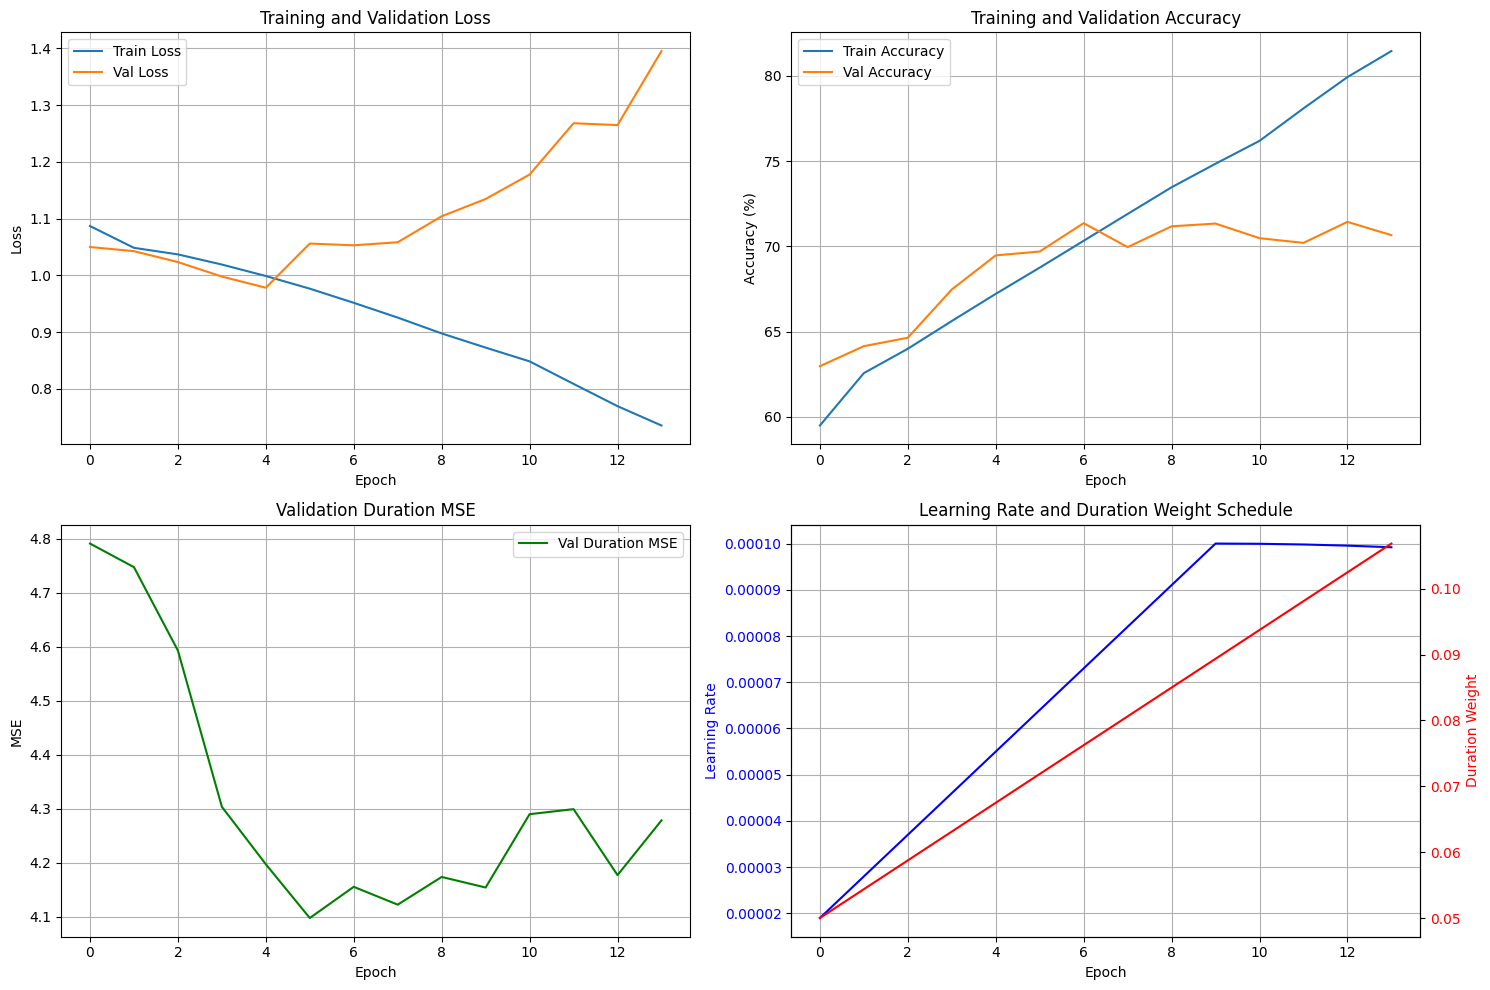

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss')
axes[0, 0].plot(history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Accuracy')
axes[0, 1].plot(history['val_acc'], label='Val Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Duration MSE
axes[1, 0].plot(history['val_duration_mse'], label='Val Duration MSE', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].set_title('Validation Duration MSE')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning Rate and Duration Weight
ax1 = axes[1, 1]
ax2 = ax1.twinx()
ax1.plot(history['learning_rate'], label='Learning Rate', color='blue')
ax2.plot(history['duration_weight'], label='Duration Weight', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Learning Rate', color='blue')
ax2.set_ylabel('Duration Weight', color='red')
ax1.set_title('Learning Rate and Duration Weight Schedule')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')
ax1.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

## Load Best Model for Evaluation

In [13]:
# Load best model
checkpoint = torch.load('checkpoints/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"Loaded best model from epoch {checkpoint['epoch'] + 1}")
print(f"Best model metrics:")
print(f"  Validation Accuracy: {checkpoint['val_acc']:.2f}%")
print(f"  Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"  Duration MSE: {checkpoint['val_duration_mse']:.4f}")
print(f"  Balanced Accuracy: {checkpoint['balanced_accuracy']:.2f}%")

Loaded best model from epoch 13
Best model metrics:
  Validation Accuracy: 71.44%
  Validation Loss: 1.2648
  Duration MSE: 4.1769
  Balanced Accuracy: 71.40%


## Final Validation Performance

In [14]:
# Run final validation
val_loss, val_acc, class_accuracies, val_duration_mse = validate(
    model, val_loader, criterion_class, criterion_duration, 
    DEVICE, CLASS_WEIGHT, checkpoint['duration_weight']
)

print("\nFinal Validation Performance:")
print(f"Overall Accuracy: {val_acc:.2f}%")
print(f"\nPer-Class Accuracy:")
print(f"  Bull: {class_accuracies['bull']:.2f}%")
print(f"  Flat: {class_accuracies['flat']:.2f}%")
print(f"  Bear: {class_accuracies['bear']:.2f}%")
print(f"\nDuration Prediction:")
print(f"  MSE: {val_duration_mse:.4f}")
print(f"  RMSE: {np.sqrt(val_duration_mse):.4f} (≈ {np.sqrt(val_duration_mse) / 0.545:.1f} days error)")


Final Validation Performance:
Overall Accuracy: 71.44%

Per-Class Accuracy:
  Bull: 75.95%
  Flat: 65.86%
  Bear: 72.38%

Duration Prediction:
  MSE: 4.1769
  RMSE: 2.0438 (≈ 3.8 days error)


## Save Training Summary

In [15]:
# Save training summary
summary = {
    'config': {
        'lookback_window': LOOKBACK_WINDOW,
        'n_features': N_FEATURES,
        'batch_size': BATCH_SIZE,
        'num_epochs': NUM_EPOCHS,
        'learning_rate': LEARNING_RATE,
        'model_params': sum(p.numel() for p in model.parameters())
    },
    'best_results': {
        'epoch': best_epoch,
        'val_accuracy': best_val_accuracy,
        'balanced_accuracy': best_balanced_accuracy,
        'duration_mse': best_duration_mse,
        'duration_rmse': np.sqrt(best_duration_mse)
    },
    'final_performance': {
        'overall_accuracy': val_acc,
        'class_accuracies': class_accuracies,
        'duration_mse': val_duration_mse
    }
}

with open('training_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\nTraining summary saved to training_summary.json")


Training summary saved to training_summary.json
